In [176]:
import rasterio
import numpy as np
from scipy import sparse

In [156]:
# Read the raster data for 2020 and convert to sparse matrix
fp1 = '../data/MBfogo_c10_cerrado_2020.tif'
fp2 = '../data/MBfogo_c10_cerrado_2019.tif'
fp3 = '../data/MBfogo_c10_cerrado_2018.tif'

In [157]:
with rasterio.open(fp1) as src:
    print(src.meta)
    width = src.width
    height = src.height
#     data = src.read(1)

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 71227, 'height': 82933, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0002694945852358564, 0.0, -60.47269846482955,
       0.0, -0.0002694945852358564, -2.3319366460458646)}


In [20]:
with rasterio.open(fp2) as src:
    print(src.meta)
    data2 = src.read(1)

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 71227, 'height': 82933, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0002694945852358564, 0.0, -60.47269846482955,
       0.0, -0.0002694945852358564, -2.3319366460458646)}


In [ ]:
with rasterio.open(fp3) as src:
    print(src.meta)
    print(src.block_windows(1))
    for ji, window in src.block_windows(1):
        print((ji, window))

## Polygonise issue

In [177]:
import sys
sys.path.append('../')
import MBfogo_raster_to_polygon as pol

In [179]:
fp = '../../_chapter01 - Copy/data/MBfogo_c10_nova-xavantina_2019.tif'
out_dir = '../../_chapter01 - Copy/data_processed/MBfogo_c10_polygons/MBfogo_c10_nova-xavantina_polygons_2019.shp'

In [19]:
%load_ext autoreload
%autoreload 2
pol.raster_to_polygon(fp, out_dir, list(range(1, 12 + 1)), connectivity = 8)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Reading raster file
Polygonising raster.
Filtering selected raster value polygons.
Saving file MBfogo_c10_nova-xavantina_polygons_2019.shp


In [9]:
import os
os.getcwd()

'C:\\Users\\scat8298\\Documents\\carlota\\projects\\_chapter01\\scripts'

In [21]:
# Checking validity of the created geomtries
import geopandas as gpd
nx_pol = gpd.read_file(out_dir)

In [22]:
nx_pol.head()

,raster_val,geometry
0,9,"POLYGON ((-51.99224 -14.41958, -51.99197 -14.4..."
1,10,"POLYGON ((-51.99090 -14.41958, -51.99063 -14.4..."
2,9,"POLYGON ((-51.98254 -14.41958, -51.98227 -14.4..."
3,9,"POLYGON ((-51.97877 -14.41958, -51.97850 -14.4..."
4,10,"POLYGON ((-51.97769 -14.41958, -51.97742 -14.4..."


In [23]:
nx_pol.geometry.is_valid

0         True
1         True
2         True
3         True
4        False
         ...  
12420    False
12421     True
12422     True
12423     True
12424     True
Length: 12425, dtype: bool

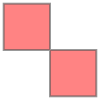

In [25]:
nx_pol.loc[4, 'geometry']

In [28]:
from shapely.validation import explain_validity

In [29]:
explain_validity(nx_pol.loc[4, 'geometry'])

'Ring Self-intersection[-51.9774206541503 -14.4198467725849]'

In [34]:
shapely.validation.make_valid(nx_pol.loc[4, 'geometry'])

AttributeError: module 'shapely.validation' has no attribute 'make_valid'

In [31]:
import shapely

In [35]:
nx_pol.loc[4, 'geometry'].is_valid

False

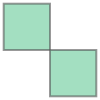

In [36]:
nx_pol.loc[4, 'geometry'].buffer(0)

In [37]:
nx_pol.loc[4, 'geometry'].geom_type

'Polygon'

In [78]:
explain_validity(nx_pol.loc[4, 'geometry'])

'Ring Self-intersection[-51.9774206541503 -14.4198467725849]'

In [42]:
nx_pol.geometry.apply(lambda geo: (geo.geom_type == 'Polygon') & (~geo.is_valid))

0        0
1        0
2        0
3        0
4        1
        ..
12420    1
12421    0
12422    0
12423    0
12424    0
Name: geometry, Length: 12425, dtype: int64

In [46]:
invalid = nx_pol.loc[~ nx_pol.geometry.is_valid, :]

In [47]:
len(invalid)

2345

In [62]:
invalid = invalid.reset_index(drop=True)

In [69]:
explain_validity(invalid.loc[5, 'geometry'])

'Ring Self-intersection[-52.0127244448502 -14.4206552563396]'

In [98]:
index = [element for element in invalid.geometry.apply(lambda x: "Ring Self-intersection" in explain_validity(x))]# if element == False]
index = [not element for element in index]


In [101]:
invalid.loc[index, 'geometry'].apply(lambda x: explain_validity(x))

451     Interior is disconnected[-52.1075865389443 -14...
1001    Interior is disconnected[-52.0431773330111 -14...
1334    Interior is disconnected[-52.0062565747983 -14...
1762    Interior is disconnected[-51.9857749863007 -14...
1844    Interior is disconnected[-52.1703787773646 -14...
2166    Interior is disconnected[-52.3835489944909 -14...
Name: geometry, dtype: object

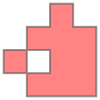

In [105]:
invalid.loc[1334    , 'geometry']

In [108]:
type(invalid.loc[1334    , 'geometry'].buffer(0))

shapely.geometry.multipolygon.MultiPolygon

In [74]:
invalid.loc[5, 'geometry'].geom_type

'MultiPolygon'

In [109]:
thing = invalid['geometry'].apply(lambda geom: geom.geom_type == 'Polygon').tolist()

In [110]:
# Trying the 'touch' option to use if I had to join polygons after polygonising using a windowed approach.
up = '../../data/cerrado_1-250000_convex-hull/cerrado_1-250000_convex-hull_upper.shp'
down = '../../data/cerrado_1-250000_convex-hull/cerrado_1-250000_convex-hull_lower.shp'

up_pol = gpd.read_file(up)
down_pol = gpd.read_file(down)

In [111]:
up_pol

,CD_Bioma,Bioma_EN,CD_LEGENDA,LEGENDA_EN,area,perimeter,geometry
0,3,Cerrado,CERRADO,CERRADO,288.010603,65.870811,"POLYGON ((-41.66072 -15.89298, -60.28302 -12.0..."


In [112]:
down_pol

,CD_Bioma,Bioma_EN,CD_LEGENDA,LEGENDA_EN,area,perimeter,geometry
0,3,Cerrado,CERRADO,CERRADO,288.010603,65.870811,"POLYGON ((-60.28302 -12.05442, -41.66072 -15.8..."


In [116]:
import pandas as pd
cerrado = gpd.GeoDataFrame( pd.concat( [up_pol, down_pol], ignore_index=True) )
cerrado

,CD_Bioma,Bioma_EN,CD_LEGENDA,LEGENDA_EN,area,perimeter,geometry
0,3,Cerrado,CERRADO,CERRADO,288.010603,65.870811,"POLYGON ((-41.66072 -15.89298, -60.28302 -12.0..."
1,3,Cerrado,CERRADO,CERRADO,288.010603,65.870811,"POLYGON ((-60.28302 -12.05442, -41.66072 -15.8..."


In [150]:
cerrado.loc[0,'geometry'].touches(cerrado.loc[1, 'geometry'])

True

In [151]:
cerrado.loc[0,'geometry'].intersects(cerrado.loc[1, 'geometry'])

True

In [149]:
cerrado.loc[0,'geometry'].crosses(cerrado.loc[1, 'geometry'])

False

In [118]:
cell01 = '../data_processed/solving_polygonise/cell01.shp'
cell02 = '../data_processed/solving_polygonise/cell02.shp'

cell01 = gpd.read_file(cell01)
cell02 = gpd.read_file(cell02)

In [124]:
cell02

,id,left,top,right,bottom,geometry
0,885.0,4.998491e+06,8.784278e+06,5.048491e+06,8.734278e+06,"POLYGON ((4998491.269 8784278.451, 5048491.269..."


In [143]:
cell01.loc[0,'geometry'].touches(cell02.loc[0, 'geometry'])

True

In [144]:
cell01.loc[0,'geometry'].intersects(cell02.loc[0, 'geometry'])

True

In [123]:
print(cell01.loc[0,'geometry'], cell02.loc[0, 'geometry'])

POLYGON ((4948491.268890875 8834278.451484475, 4998491.268890875 8834278.451484475, 4998491.268890875 8784278.451484475, 4948491.268890875 8784278.451484475, 4948491.268890875 8834278.451484475)) POLYGON ((4998491.268890875 8784278.451484475, 5048491.268890875 8784278.451484475, 5048491.268890875 8734278.451484475, 4998491.268890875 8734278.451484475, 4998491.268890875 8784278.451484475))


In [125]:
# Can I disolve these two polygons into one?
cells = gpd.GeoDataFrame( pd.concat( [cell01, cell02], ignore_index=True) )
cells['dissolve'] = 34
cells

,id,left,top,right,bottom,geometry,dissolve
0,830.0,4.948491e+06,8.834278e+06,4.998491e+06,8.784278e+06,"POLYGON ((4948491.269 8834278.451, 4998491.269...",34
1,885.0,4.998491e+06,8.784278e+06,5.048491e+06,8.734278e+06,"POLYGON ((4998491.269 8784278.451, 5048491.269...",34


In [134]:
dissolved = cells.dissolve(by='dissolve').reset_index(drop=True)
dissolved

,geometry,id,left,top,right,bottom
0,"MULTIPOLYGON (((5048491.269 8784278.451, 50484...",830.0,4.948491e+06,8.834278e+06,4.998491e+06,8.784278e+06


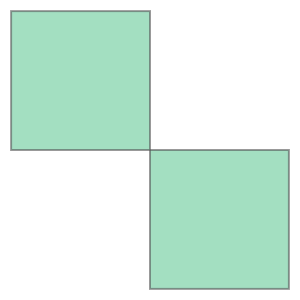

In [136]:
dissolved.loc[0, 'geometry']

In [137]:
# Another way to get to the same result
from shapely.ops import unary_union

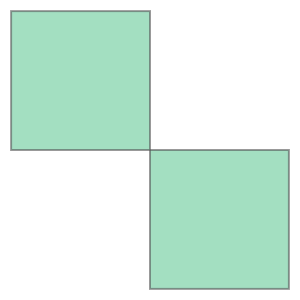

In [141]:
unary_union([cells.loc[0, 'geometry'], cells.loc[1, 'geometry']])

In [142]:
cells.loc[0, 'geometry'].intersects(cells.loc[1, 'geometry'])

True

In [145]:
gpd.clip(cells.loc[0, 'geometry'], cells.loc[1, 'geometry'])

TypeError: 'gdf' should be GeoDataFrame or GeoSeries, got <class 'shapely.geometry.polygon.Polygon'>

In [148]:
cells.loc[0, 'geometry'].crosses(cells.loc[1, 'geometry'])

False

#### Checking crosses matrix algorithm

In [186]:
# REad the polygons
polygons = gpd.read_file(out_dir)

In [187]:
polygons.head()

,raster_val,geometry
0,9,"POLYGON ((-51.99224 -14.41958, -51.99197 -14.4..."
1,10,"POLYGON ((-51.99090 -14.41958, -51.99063 -14.4..."
2,9,"POLYGON ((-51.98254 -14.41958, -51.98227 -14.4..."
3,9,"POLYGON ((-51.97877 -14.41958, -51.97850 -14.4..."
4,10,"POLYGON ((-51.97769 -14.41958, -51.97742 -14.4..."


In [188]:
# Check if there are invalid polygons
print(polygons.shape[0])
print(polygons.loc[ ~polygons['geometry'].is_valid, :].shape[0])

12425
2345


In [184]:
# There are, so apply unary union to resolve
polygons['geometry'] = polygons['geometry'].apply(lambda geo: unary_union(geo))
print(polygons.loc[ ~polygons['geometry'].is_valid, :].shape[0])

1762


In [190]:
# There are, so apply buffer to resolve
polygons['geometry'] = polygons['geometry'].apply(lambda geo: geo.buffer(0))
print(polygons.loc[ ~polygons['geometry'].is_valid, :].shape[0])

0


In [193]:
# Check if any polygons cross one another
# Create matrix of crosses
from pytictoc import TicToc
t = TicToc()
t.tic()
crosses_matrix = polygons['geometry'].apply(lambda x: polygons['geometry'].crosses(x)).values.astype(int)
t.toc()

Elapsed time is 828.531627 seconds.


In [194]:
t.tic()
print(np.sum(crosses_matrix))
t.toc()

0
Elapsed time is 0.064067 seconds.


## Polygonise issue with a larger cell (cell 03)

In [172]:
import sys
sys.path.append('../')
import MBfogo_raster_to_polygon as pol

In [174]:
fp = '../data/MBfogo_c10_test-cell03_2019.tif'
out_dir = '../data_processed/MBfogo_c10_polygons/MBfogo_c10_test-cell03_polygons_2019.shp'

In [175]:
%load_ext autoreload
%autoreload 2
pol.raster_to_polygon(fp, out_dir, list(range(1, 12 + 1)), connectivity = 8)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Reading raster file
Polygonising raster.
Filtering selected raster value polygons.
Saving file MBfogo_c10_test-cell03_polygons_2019.shp


## Windowed operation
The algorithm seems to have worked fine in a grid of 60 km, which 2000 pixels. Let's perhaps use this grid size?

In [158]:
cell_size = 2000

In [161]:
# This cell size implies a number of cells in the horizontal direction:
print(int(width / cell_size))
print(width % cell_size)

35
1227


In [163]:
35 * cell_size + 1227 == width

True

In [164]:
# And in the vertical direction
print(int(height / cell_size))
print(height % cell_size)

41
933


In [168]:
# This implies a total number of cells 
35 * 41

1435

In [165]:
# Taking into acount that a large number of these cells will be fully empty (all zeros)
empty_area_m2 = 1356516532689.186 + 418622030914.650 + 251164439497.030

In [166]:
cell_size_m2 = 60000*60000

In [167]:
empty_area_m2 / cell_size_m2

562.8619453057961

In [170]:
# Hence, in the end I will operate on about a number of cells:
35 * 41 - 560

875

In [171]:
# Using 20 workers 
875/20

43.75